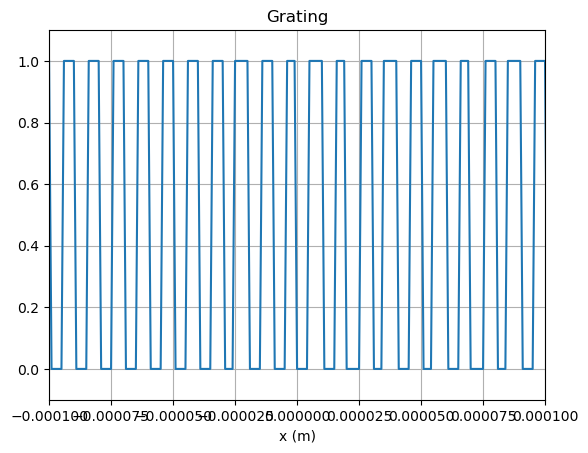

In [162]:
import numpy as np
import matplotlib.pyplot as plt

def propTF(uin_V_m, L_m, lambda_m, z_m):
    M = uin_V_m.size        # number of samples (grid points)
    dx_m = L_m/M            # grid spacing
    k_1_m = 2*np.pi/lambda_m # wavenumber

    # Frequency coordinates
    fx_1_m = np.linspace(-1/(2*dx_m), 1/(2*dx_m) - (1/L_m), M)
    
    # Transfer function for Fresnel propagation
    H = np.exp(-1j * np.pi * lambda_m * z_m * (fx_1_m**2))
    H = np.fft.fftshift(H)

    # Fourier transform input field
    Uin_V_m = np.fft.fft(np.fft.fftshift(uin_V_m))

    # Multiply in Fourier space
    Uout_V_m = H * Uin_V_m

    # Inverse FFT → propagated field
    uout_V_m = np.fft.ifftshift(np.fft.ifft(Uout_V_m))
    return uout_V_m


period_m = (10)*1e-6

wavelength_m = 500e-9
dx_m = 1e-6
Dx_m = 1
x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m)+1)
x_mean_m = 0.0
x_std_m = 25e-6
g = np.exp(-(x_m - x_mean_m)**2/(2*(x_std_m**2)))
E0 = np.sqrt(g)

grating = np.sin(2 * np.pi * x_m / period_m) < 0

plt.plot(x_m, grating)
plt.title('Grating')
plt.xlabel('x (m)')
plt.xlim(-1e-4, 1e-4)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.show()



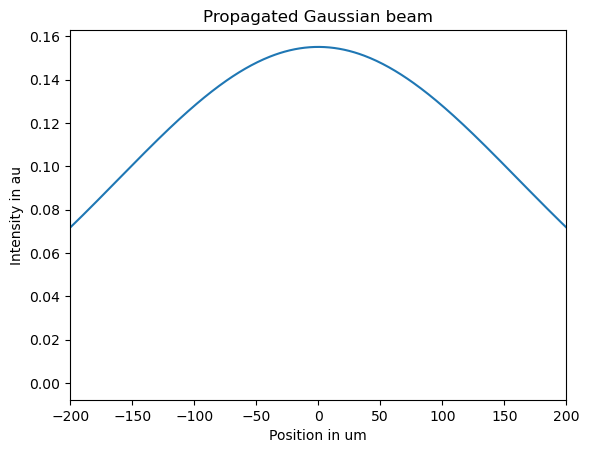

In [163]:
#initial beam electric field

wavelength_m = 500e-9 #wavelength, m
zp_m = 100e-3 #propagation distance, m

E0 = np.sqrt(g) # initial field amplitude squared equals the Gaussian intensity defined earlier 
Ep = propTF(E0, Dx_m, wavelength_m, zp_m) # propTF propagates that field forward by a distance zp_m 

Ip = np.abs(Ep)**2 # intensity 

plt.plot(x_m*1e6, Ip)
plt.xlabel("Position in um")
plt.ylabel("Intensity in au") #arbitrary units
plt.title("Propagated Gaussian beam")
plt.xlim(-200, 200)
plt.show()

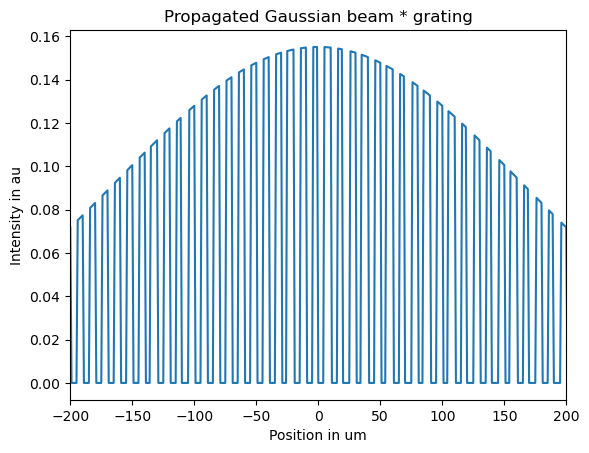

In [164]:
Eg = Ep * grating 

Ig = np.abs(Eg)**2

plt.plot(x_m*1e6, Ig)
plt.xlabel("Position in um")
plt.ylabel("Intensity in au") #arbitrary units
plt.title("Propagated Gaussian beam * grating")
plt.xlim(-200, 200)
plt.show()

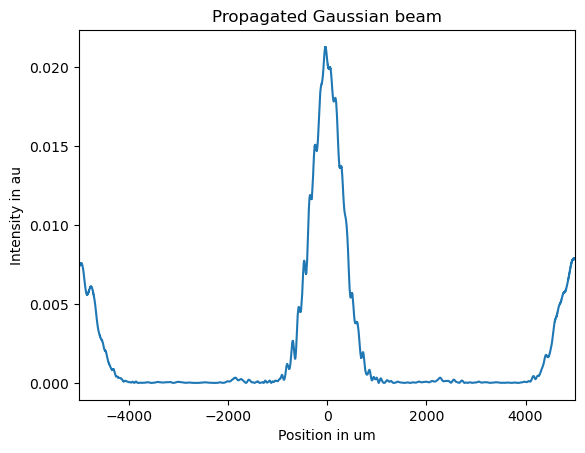

In [165]:
Ed = propTF(Eg, Dx_m, wavelength_m, zp_m) # propTF propagates that field forward by a distance zp_m 

Id = np.abs(Ed)**2 # intensity 

plt.plot(x_m*1e6, Id)
plt.xlabel("Position in um")
plt.ylabel("Intensity in au") #arbitrary units
plt.title("Propagated Gaussian beam")
plt.xlim(-5000, 5000)
plt.show()

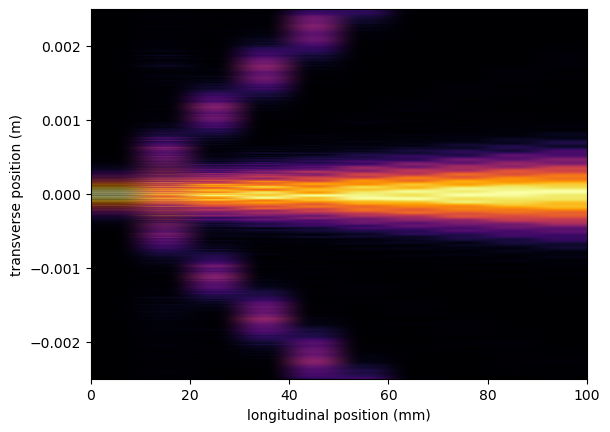

In [166]:
Z = np.linspace(0, 0.1, 10)  
sim_beam_sizes = []

Ixz = np.zeros((len(Z), len(x_m)))
for z in Z:
    Ed = propTF(Eg, Dx_m, wavelength_m, z) # propTF propagates that field forward by a distance z
    Id = np.abs(Ed)**2 # intensity
    Ixz[z == Z, :] = Id / np.max(Id)  # normalized intensity
    x_mean = np.sum(x_m * Id) / np.sum(Id)
    x_std = np.sqrt(np.sum((x_m - x_mean)**2 * Id) / np.sum(Id))
    sim_beam_sizes.append(x_std)

sim_beam_sizes = np.array(sim_beam_sizes)



plt.imshow(np.transpose(Ixz),
           extent=[Z[0]*1e3, Z[-1]*1e3,x_m[0], x_m[-1]],
           aspect='auto',
           cmap='inferno')
plt.ylim([-0.0025, 0.0025])
plt.xlabel("longitudinal position (mm)")
plt.ylabel("transverse position (m)")
plt.xlim([0,100])
plt.show()            

In [167]:
# measure the angle between main beam and diffracted beam !!! (displacement/distance) 

# then, vary the pitch (period) and compare angles to theoretical (factor of 2 maybe)

# theory: sin(theta) = lambda / period  (for first order)

# x_mean = np.sum(x_m * Ip) / np.sum(Ip) measures centroid 

# use x_mean but remove the main beam


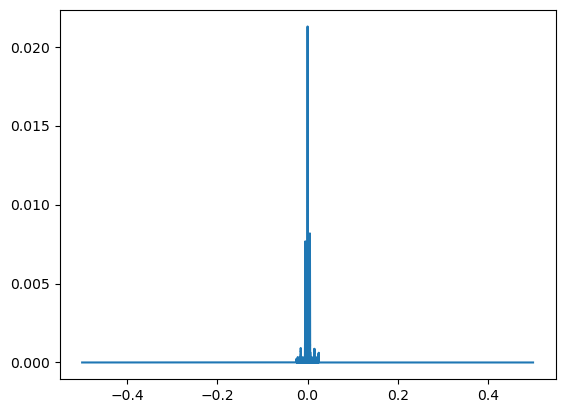

In [168]:
plt.plot(x_m, Id)

Displacement: -0.005121025000025042, Angle: 2.935415163449701 degrees


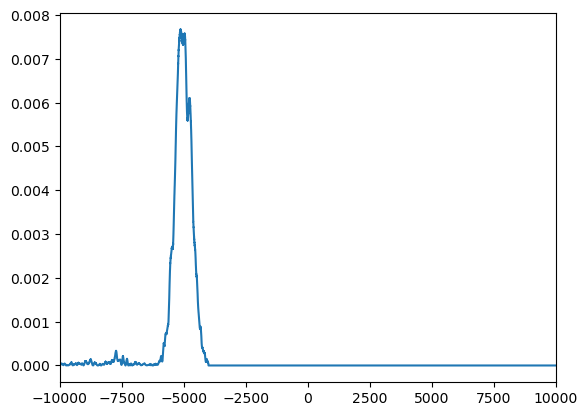

In [169]:
# Calculate center of the main beam intensity
x_mean_main = np.sum(x_m * Ip) / np.sum(Ip)

# Remove main beam region from consideration
main_beam_width_m = 4e-3  # width around the main beam to exclude
Id_masked = Id.copy()   
Id_masked[(x_m + main_beam_width_m) > 0]=0



# np.abs(x_m - x_mean_main) < main_beam_width_m] = 0



# First significant diffraction peak position 
first_diffracted_peak_pos = x_m[np.argmax(Id_masked)]  

# first_diffracted_peak_pos = np.sum(x_m * Id_masked) / np.sum(Id_masked)


# Calculate displacement and distance
displacement_m = first_diffracted_peak_pos - x_mean_main
distance = zp_m  # used propagation distance
angle = np.arcsin(displacement_m / distance)  # angle in radians
angle_degrees = abs(np.degrees(angle))  # convert to degrees

print(f"Displacement: {displacement_m}, Angle: {angle_degrees} degrees")

plt.plot(x_m*1e6,Id_masked)

# plt.xlim(-0.01,0.01)

plt.xlim(-10000,10000)
plt.show()


In [170]:
# theory: sin(theta) = lambda / period  (for first order) 

theta_theory = np.arcsin(wavelength_m / period_m)

print(f"Theoretical angle: {np.degrees(theta_theory)} degrees")

Theoretical angle: 2.8659839825988622 degrees


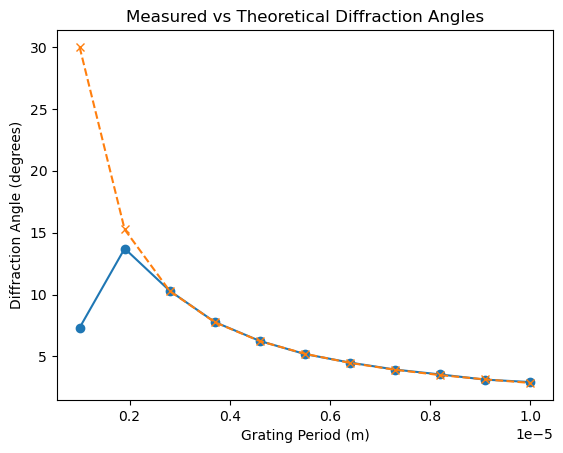

In [180]:
periods_m = np.linspace(1e-6,10e-6, 11)  # periods from 5 um to 20 um

angles_theory = []
angles_measured = []

for period_m in periods_m:
    grating = np.sin(2 * np.pi * x_m / period_m) < 0  # Update grating
    Eg = Ep * grating 
    Ed = propTF(Eg, Dx_m, wavelength_m, zp_m)
    Id = np.abs(Ed)**2
    Id_masked = Id.copy()   
    Id_masked[(x_m + main_beam_width_m) > 0]=0

    # Calculate center of the main beam intensity
    # x_mean_main = np.sum(x_m * Id_masked) / np.sum(Id_masked)

    # First significant diffraction peak position 
    first_diffracted_peak_pos = x_m[np.argmax(Id_masked)]  

    # Calculate displacement and distance
    displacement_m = first_diffracted_peak_pos - x_mean_main
    distance = zp_m  # used propagation distance
    angle = np.arcsin(displacement_m / distance)  # angle in radians
    angle_degrees = abs(np.degrees(angle))  # convert to degrees

    theta_theory = np.arcsin(wavelength_m / period_m)

    angles_theory.append(np.degrees(theta_theory))
    angles_measured.append(angle_degrees)

    # print(f"Theoretical angle: {np.degrees(theta_theory)} degrees")
    # print(f"Displacement for period {period_m}: {displacement_m}, Angle: {angle_degrees} degrees")

plt.plot(periods_m, angles_measured, 'o-', label='Measured Angles')
plt.plot(periods_m, angles_theory, 'x--', label='Theoretical Angles')
plt.xlabel('Grating Period (m)')
plt.ylabel('Diffraction Angle (degrees)')
plt.title('Measured vs Theoretical Diffraction Angles')
plt.show()

In [ ]:
# why outlier when too high or low period 

In [172]:
# see what happens w one slit first 

#then see two slits

# simulate young's double slit experiment 

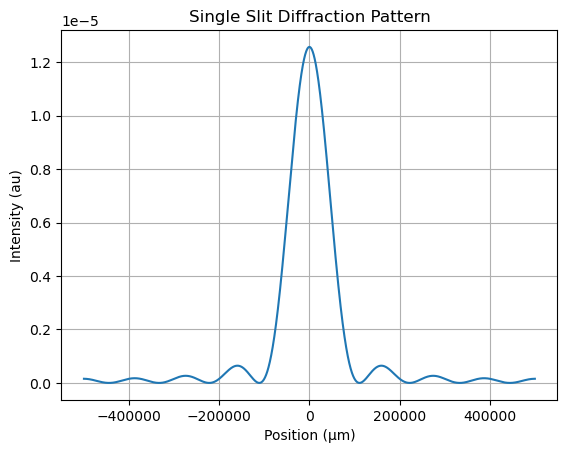

In [194]:
# Single slit 

slit_width_m = 10e-6
slit_position = (-slit_width_m / 2, slit_width_m / 2)  

single_slit = (x_m >= slit_position[0]) & (x_m <= slit_position[1])

E_single_slit = Ep * single_slit
I_single_slit = np.abs(E_single_slit)**2  

# Propagate through the single slit
Ez_single_slit = propTF(E_single_slit, Dx_m, wavelength_m, 2)
I_single_slit_out = np.abs(Ez_single_slit)**2  # Output intensity



min_intensity = np.min(I_single_slit_out)
max_intensity = np.max(I_single_slit_out)


plt.figure()
plt.plot(x_m * 1e6, I_single_slit_out)  
plt.title("Single Slit Diffraction Pattern")
plt.xlabel("Position (µm)")
plt.ylabel("Intensity (au)")  


# incr sl


plt.grid()
plt.show()

# y not scaling right ????

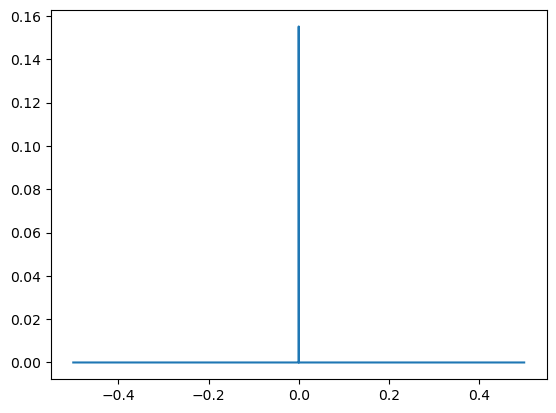

In [191]:
plt.plot(x_m,I_single_slit)

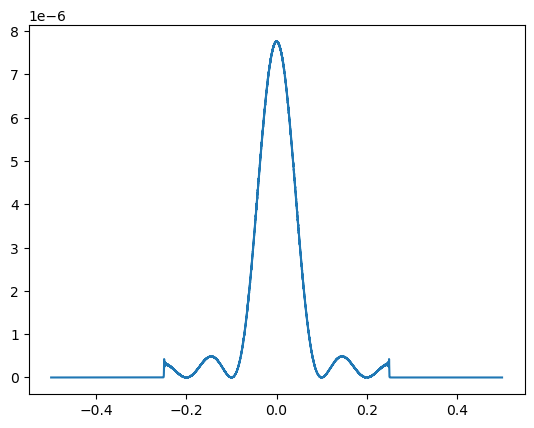

In [192]:
plt.plot(x_m,I_single_slit_out)

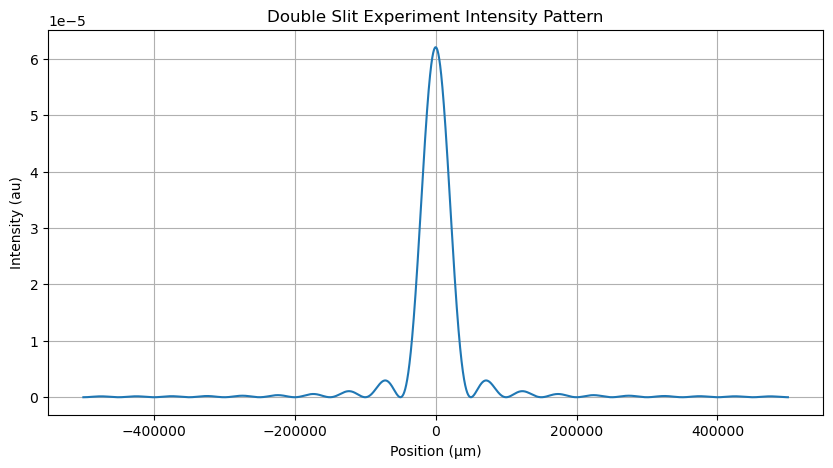

(-300.0, 300.0)

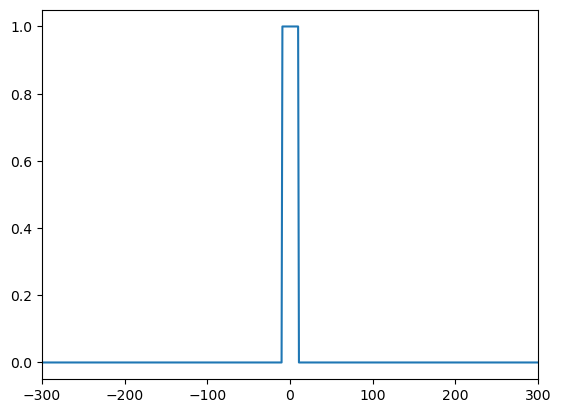

In [202]:
# 2. Double Slit Experiment

slit_spacing_m = 10e-6  # Distance between the centers of the two slits
slit1_position_m = (-slit_width_m / 2 - slit_spacing_m / 2, slit_width_m / 2 - slit_spacing_m / 2)
slit2_position_m = (-slit_width_m / 2 + slit_spacing_m / 2, slit_width_m / 2 + slit_spacing_m / 2)


double_slit = ((x_m >= slit1_position_m[0]) & (x_m <= slit1_position_m[1])) | \
              ((x_m >= slit2_position_m[0]) & (x_m <= slit2_position_m[1]))


double_slit = np.abs((np.abs(x_m) - slit_spacing_m/2) < (slit_width_m/2))


E_double_slit = Ep * double_slit
I_double_slit = np.abs(E_double_slit)**2  


Ez_double_slit = propTF(E_double_slit, Dx_m, wavelength_m, 2)
I_double_slit_out = np.abs(Ez_double_slit)**2  # Output intensity


plt.figure(figsize=(10, 5))
plt.plot(x_m * 1e6, I_double_slit_out)  
plt.title("Double Slit Experiment Intensity Pattern")
plt.xlabel("Position (µm)")
plt.ylabel("Intensity (au)")

plt.grid()
plt.show() 

plt.plot(x_m*1e6,double_slit)
plt.xlim(-300,300)


# y limit problem again ????

In [ ]:
# make this two 

# start w gaussian beam and propagate, E1

# create another E2 and back propagate (go to neg differences) 

# compute E1 + E2 and take np.abs()**2, and  np.angle()

# take E1, multiply by np.angle from above, propagate it further and see what happens 

# if multiply beam by interference, should focus the beam 